## Introduction 

This notebook will go over optimization of multiple response variables using the IbottaUplift Framework. Readers are encouraged to read the [example on single responses](https://github.com/Ibotta/ibotta_uplift/blob/master/examples/ibotta_uplift_multiple_response_example.ipynb) if they'd like a general introduction to uplift models. This will go over:

1. Hypothetical Problem and The Data Generating Process

2. Building / Gridsearching the Uplift Model 

3. Evaluating the Tradeoffs with the out-of-sample ERUPT metric

4. Assign Optimal Treatments for New Observations 

In [1]:
import numpy as np
import pandas as pd

from ibotta_uplift.dataset.data_simulation import get_simple_uplift_data
from ibotta_uplift.ibotta_uplift import IbottaUplift
from ggplot import *

/Users/samweiss/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/samweiss/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/samweiss/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/samweiss/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is depre

### Business Problem 

Imagine we are data scientists working for a startup that would like to grow the business more but in an efficient way. 

As a tactic to increase user activity the company gives all users a potentially expensive treatment. In order to reduce costs we were assigned the task of using data to find a subset of users that should continue receiving the costly treatment while continue increasing growth as measured by revenue. 

The company would rather have and increase in revenue even if it decreases overall profitiability. However, we do not know the relative tradeoff of growth in revenue vs profitibility the business would like to take. 

If we knew the relative tradeoffs we could create a new variable $y_{new} = (1-a)*revenue - a*costs$ and maximize $y_{new}$ as a normal uplift problem (see example 1). Since we don't know the value of $a$ we will have to calculate the tradeoffs first and then decide the optimal value. 

This problem therefore entails both finding users and evaluating tradeoffs among different response variables. 

We are given some explanatory variables for users $x$, a random treatment of whether a users recieved marketing campaign or not $t$, and response variable of profitibility $y$. 

We can use  IbottaUplift to find the tradeoff between increases in revenue vs the increase in costs. Once we have found a suitable tradeoff we can then use the model to target users that should recieve the treatment given our new objectives.


### Data Generating Process

Below is the data generating process of the data we have. (I have included a noise response variable to demonstrate what happens when we try to model noise.)

\begin{equation}
x_1  \sim runif(0,1)
\end{equation}

\begin{equation}
x_2 \sim runif(0,1)
\end{equation}

\begin{equation}
e_1 \sim rnorm(0,1)
\end{equation}

\begin{equation}
e_2 \sim rnorm(0,1)
\end{equation}

\begin{equation}
t \sim rbinom(.5)
\end{equation}

\begin{equation}
noise \sim rnorm(0,1)
\end{equation}

\begin{equation}
revenue = x_1*t + e_1
\end{equation}

\begin{equation}
costs = x_2*t + e_2
\end{equation}

\begin{equation}
profit = revenue - costs
\end{equation}




In [4]:
y, x, t = get_simple_uplift_data(10000)

y = pd.DataFrame(y)
y.columns = ['revenue','cost', 'noise']
y['profit'] = y['revenue'] - y['cost']

In [6]:
x = pd.DataFrame(x)
x['noise'] = np.random.normal(0, 1, 10000)

### Model Building / Gridsearch
After instantiating the IbottaUplift class the `.fit` function will build the model. It first seperates the data into a train / test split. It builds standard scaler transformerd on all variables $x, y, t$.

Then it builds and runs grisdesarch using keras neural network model that minimizes the mean squared error of the form $y = f(t,x)$. The user can input a custom parameter grid. 


In [7]:
uplift_model = IbottaUplift()
param_grid = dict(num_nodes=[8], dropout=[.1,.5], activation=[
                          'relu'], num_layers=[1,2], epochs=[25], batch_size=[30])



uplift_model.fit(x, y, t.reshape(-1,1), param_grid = param_grid, n_jobs = 1)

uplift_model.permutation_varimp(weights = np.array([.6,-.4,0,0]).reshape(1,-1))

/Users/samweiss/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


          0
0  0.378143
1  0.233714
2  0.000714


,permuation_varimp_metric,var_names
0,0.378143,0
1,0.233714,1
2,0.000714,noise


In [8]:
uplift_model.permutation_varimp(weights = np.array([.4,-.6,0,0]).reshape(1,-1))

/Users/samweiss/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


          0
0  0.241143
1  0.349857
2  0.001429


,permuation_varimp_metric,var_names
0,0.241143,0
1,0.349857,1
2,0.001429,noise


### Evaluating Tradeoffs using out-of-sample ERUPT Curves

Using the test dataset IbottaUplift will then evaluate the model using the ERUPT metrics with different objective weights with the `get_erupt_curves` function. 

Continuing the notation from the [single response example](https://github.com/Ibotta/ibotta_uplift/blob/master/examples/ibotta_uplift_multiple_response_example.ipynb) the policy assignment is expanded to include weights $W$ below: 

\begin{equation}
    \pi(x_i, W) =argmax \:_{t \in T} \sum_j w_j *E[y_{j,i} | X=x_i, T=t]
\end{equation}

Each objective weights will consist of an array equal to the number of responses. With these weights it calculates a new variable based on predictions to maximize $y_{new} = weight_0*\hat{y_0} + weight_1*\hat{y_1} + ... + weight_{num responses}*\hat{y_{num responses}}$. 

Varying the objective weights allows us to see what happens when we change the focus of model from a revenue maximizing problem to a cost minimizing problem. 


The `get_erupt_curves` function outputs two dataframes:

1) The first is the ERUPT metric and standard deviation for all response variables given a set of model weights. In this example the weights are set up to go from a cost minimizing to a revenue maximimization objective. We see both costs and revenue go up but at different rates. Profit is maximized when the revenue weight is .5 and cost weight is .5. Finally we can also see the noise response variable is not effected as expected. 


2) The second pandas df shows the distribution of treatments under the optimal assignment for a set of objective weights. In this example we can see those assigned the treatment increase as we weight the objective function towards to be more revenue maximization.




/Users/samweiss/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


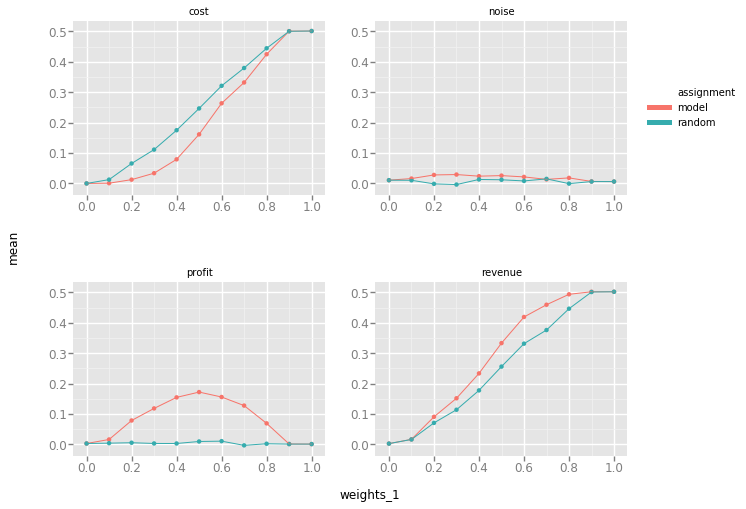

<ggplot: (-9223372036555612142)>

In [4]:
erupt_curves, dists = uplift_model.get_erupt_curves()

#I create a new variable that shows the weight of the revenue variable
dists['weights_1'] = [np.float(x.split(',')[0]) for x in dists['weights']]
erupt_curves['weights_1'] = [np.float(x.split(',')[0]) for x in erupt_curves['weights']]

ggplot(aes(x='weights_1', y='mean', group = 'assignment', colour = 'assignment'), data=erupt_curves) +\
    geom_line()+\
    geom_point()+facet_wrap("response_var_names")

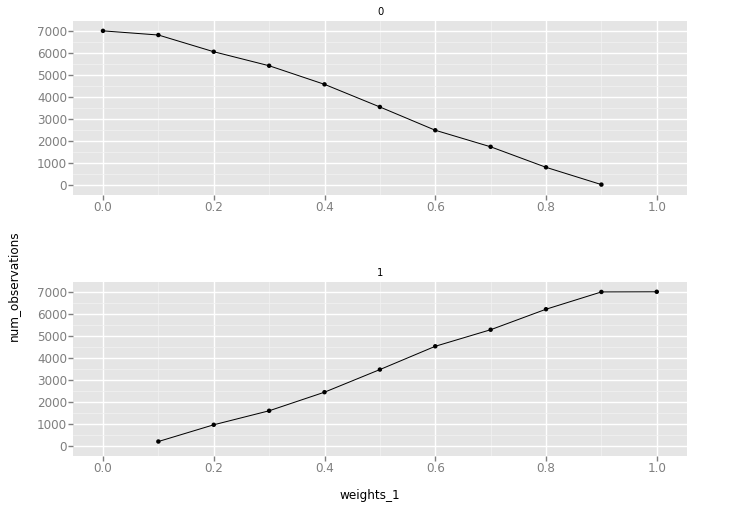

<ggplot: (-9223372036563565452)>

In [5]:
ggplot(aes(x='weights_1', y='num_observations'), data=dists) +\
    geom_line()+\
    geom_point()+facet_wrap('tmt')

### Assigning Optimal Treatments for new observations
After building and evaluating an uplift model the modeller may deem it worthy of production. To assign new users the optimal treatment one can use the `predict_optimal_treatments` function to do so below but now requires a weights assignment.
I have chosen a weights assignment of .6 for revenue and -.4 for costs to be more alligned with the business objective. 


In [6]:
#generate 5 new observation
_, x_new ,_  = get_simple_uplift_data(5)
uplift_model.predict_optimal_treatments(x_new, weights = np.array([.6,-.4,0,0]).reshape(1,-1))

/Users/samweiss/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[1],
       [1],
       [0],
       [1],
       [1]])

UnboundLocalError: local variable 'x_copy' referenced before assignment